In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [35]:
# Mapping Kolom Program Studi dan Jalur Seleksi
dataset_prev = pd.read_excel('../pbl/Dataset for ML.xlsx')
program_studi_mapping = {
    "Teknik Elektronika": 1,
    "Teknik Telekomunikasi": 2,
    "Teknik Elektro Industri": 3,
    "Teknik Informatika": 4,
    "Teknik Mekatronika": 5,
    "Teknik Komputer": 6,
    "Teknologi Multimedia Broadcasting": 7,
    "Sistem Pembangkit Energi": 8,
    "Teknologi Game": 9,
    "Teknologi Rekayasa Internet": 10,
    "Teknologi Rekayasa Multimedia": 11,
    "Sains Data Terapan": 12
}
dataset_prev['Program Studi'] = dataset_prev['Program Studi'].map(program_studi_mapping)

In [36]:
df = pd.read_csv('dataset_for_ml_fix.csv',delimiter=';')
df.head()

,id,jenjang_pendidikan,minat_bakat,jalur_pendaftaran,rata_nilai,rencana_karir,prodi_rekomendasi_id
0,1,D3,"Fisika, Teknik Tenaga Listrik (TTL)",Jalur Tes Tulis,830.0,Network Engineer,2
1,2,D3,"Kimia, Teknologi Komputer Jaringan (TKJ)",Jalur Prestasi,91.0,Broadcast Engineer,7
2,3,D4,"Pemrograman, Statistika, Teknologi Komputer Ja...",Jalur Prestasi,95.6,Machine Learning Engineer,12
3,4,D4,"Teknik Instalasi Tenaga Listrik (TITL), Teknol...",Jalur Prestasi,86.1,Game Designer,9
4,5,D4,"Fisika, Matematika, Desain Animasi",Jalur Test Tulis,882.7,Digital Content Creator,11


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   jenjang_pendidikan    1000 non-null   object 
 2   minat_bakat           1000 non-null   object 
 3   jalur_pendaftaran     1000 non-null   object 
 4   rata_nilai            1000 non-null   float64
 5   rencana_karir         1000 non-null   object 
 6   prodi_rekomendasi_id  1000 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB


# Feature Engineering

In [38]:
# === OHE FITUR MINAT_BAKAT ===
minat_bakat_dummies = df['minat_bakat'].str.get_dummies(sep=', ')
df = pd.concat([df, minat_bakat_dummies], axis=1)

# === DROP COLUMN ===
df = df.drop(columns=['minat_bakat'], axis=1)

# === SPLIT TRAIN-TEST DATA ===
X = df.drop('prodi_rekomendasi_id', axis=1)
y = df['prodi_rekomendasi_id']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=4824
)

# === IDENTIFIKASI FEATURES ===
numeric_features = ['rata_nilai']
categorical_target = ['jenjang_pendidikan', 'jalur_pendaftaran', 'rencana_karir']

# === NORMALISASI ===
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# === ENCODING ===
target_transformer = Pipeline(steps=[
    ('target_enc', TargetEncoder())
])

# === PREPROCESSING ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('target', target_transformer, categorical_target)
    ],
    remainder='passthrough',  # fitur one-hot Minat dan Bakat tidak hilang
    sparse_threshold=0
)

In [39]:
# Transformasi X_train menggunakan preprocessor
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# Ambil nama kolom hasil transformasi:
# - Kolom numeric setelah scaling
transformed_cols = numeric_features.copy()

# - Kolom categorical yang di-encode
transformed_cols += [f"{col}_enc" for col in categorical_target]

# - Kolom yang di-passthrough (sisa kolom lain, termasuk one-hot Minat dan Bakat)
passthrough_cols = [col for col in X_train.columns if col not in numeric_features + categorical_target]
transformed_cols += passthrough_cols

# Buat dataframe dari hasil transformasi
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_cols, index=X_train.index)

# Tampilkan hasil transformasi
X_train_transformed_df.head()


,rata_nilai,jenjang_pendidikan_enc,jalur_pendaftaran_enc,rencana_karir_enc,id,Desain Animasi,Desain Grafis,Elektronika,Fisika,Kimia,Matematika,Multimedia,Pemrograman,Statistika,Teknik Instalasi Tenaga Listrik (TITL),Teknik Tenaga Listrik (TTL),Teknologi Komputer Jaringan (TKJ)
708,-1.006885,7.188300,6.466454,5.946138,709.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
476,-1.013741,4.130723,6.466454,6.668812,477.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
813,1.219610,4.130723,6.756906,4.091290,814.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
146,-1.031843,7.188300,6.466454,5.797968,147.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
422,1.286806,4.130723,6.756906,6.795732,423.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Baseline Model

In [40]:
# === MODEL DECISION TREE ===
baseline_pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

baseline_pipe_dt.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI ===
y_pred_train = baseline_pipe_dt.predict(X_train)
y_pred_test = baseline_pipe_dt.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Baseline Decision Tree Accuracy on Train Set: {train_acc:.4f}")
print(f"Baseline Decision Tree Accuracy on Test Set : {test_acc:.4f}")


Baseline Decision Tree Accuracy on Train Set: 1.0000
Baseline Decision Tree Accuracy on Test Set : 0.9733


In [41]:
# === MODEL RANDOM FOREST ===
baseline_pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

baseline_pipe_rf.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI ===
y_pred_train = baseline_pipe_rf.predict(X_train)
y_pred_test = baseline_pipe_rf.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Baseline Random Forest Accuracy on Train Set: {train_acc:.4f}")
print(f"Baseline Random Forest Accuracy on Test Set : {test_acc:.4f}")


Baseline Random Forest Accuracy on Train Set: 1.0000
Baseline Random Forest Accuracy on Test Set : 0.7133


In [42]:
# === MODEL EXTRA TREES ===
baseline_pipe_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

baseline_pipe_et.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI ===
y_pred_train = baseline_pipe_et.predict(X_train)
y_pred_test = baseline_pipe_et.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Baseline Extra Tree Accuracy on Train Set: {train_acc:.4f}")
print(f"Baseline Extra Tree Accuracy on Test Set : {test_acc:.4f}")


Baseline Extra Tree Accuracy on Train Set: 1.0000
Baseline Extra Tree Accuracy on Test Set : 0.6767


# Hyperparameter Tuning

In [43]:
# === DECISION TREE CLASSIFIER ===
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# === HYPERPARAMETER GRID ===
param_grid = {
    'classifier__criterion': ['entropy', 'gini'],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': [1.0, 'sqrt', 'log2'],
    'classifier__min_impurity_decrease': [0.0, 0.001],
    'classifier__splitter': ['best', 'random']
}

# === CROSS VALIDATION & GRID SEARCH ===
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipe, param_grid, cv=skf, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"\nBest Hyperparameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Fitting 10 folds for each of 864 candidates, totalling 8640 fits

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 1.0, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}
Best CV Accuracy: 0.9786


# Model Evaluation

In [44]:
# === EVALUASI DI TRAIN SET ===
y_pred_train = grid_search.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f"Train Set Accuracy: {train_acc:.4f}")

# === EVALUASI DI TEST SET ===
y_pred_test = grid_search.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {test_acc:.4f}")

Train Set Accuracy: 0.9914
Test Set Accuracy: 0.9733


In [48]:
# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        26
           3       0.92      0.79      0.85        29
           4       1.00      1.00      1.00        24
           5       0.77      0.91      0.83        22
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        21

    accuracy                           0.97       300
   macro avg       0.97      0.98      0.97       300
weighted avg       0.98      0.97      0.97       300



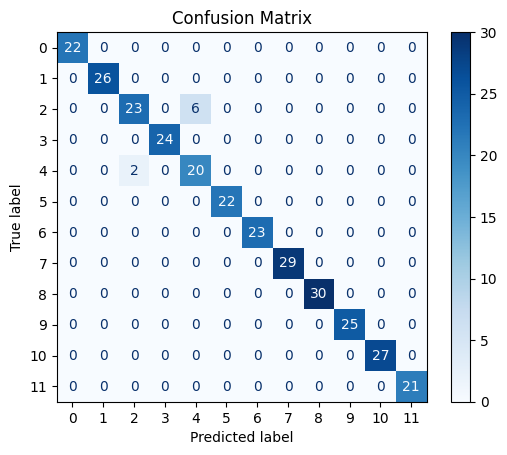

In [53]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

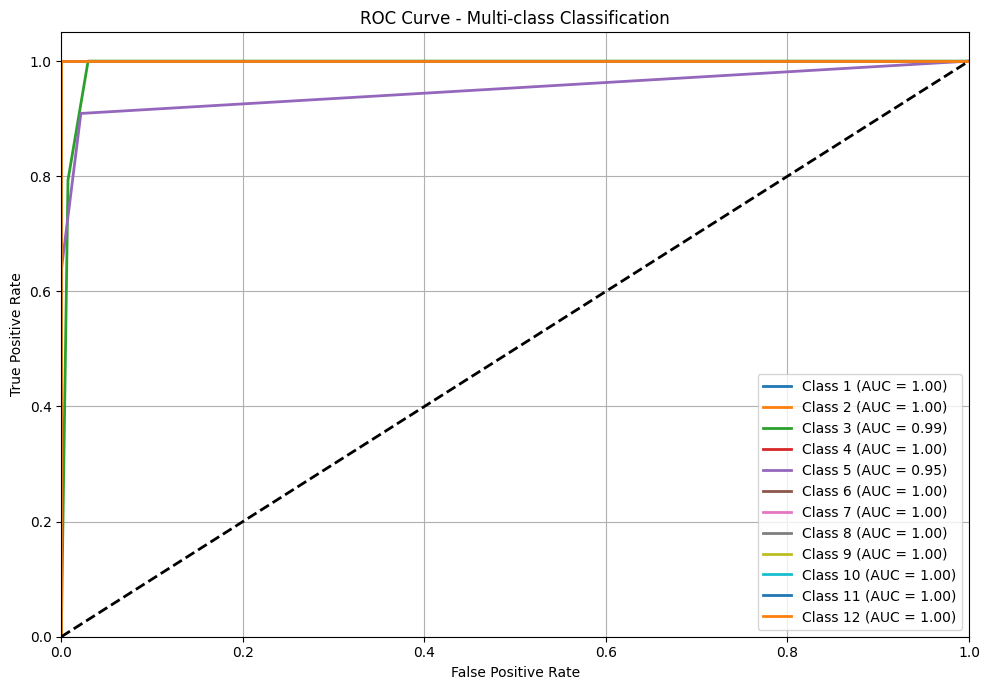

In [54]:
# === ROC CURVE FOR MULTICLASS ===
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=grid_search.classes_)
y_score = grid_search.predict_proba(X_test)

n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {grid_search.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
best_model = grid_search.best_estimator_

def prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping):
    # Menyamakan kolom dataset dengan hasil training model
    minat_bakat_columns = [col for col in X_train.columns if col not in numeric_features + categorical_target]

    minat_bakat_dummies = data_baru['minat_bakat'].str.get_dummies(sep=', ')
    for col in minat_bakat_columns:
        if col not in minat_bakat_dummies.columns:
            minat_bakat_dummies[col] = 0
    minat_bakat_dummies = minat_bakat_dummies[minat_bakat_columns]

    data_baru_processed = data_baru.drop('minat_bakat', axis=1)
    data_baru_final = pd.concat([data_baru_processed, minat_bakat_dummies], axis=1)
    data_baru_final = data_baru_final[X_train.columns]

    # Prediksi data baru
    prediksi = best_model.predict(data_baru_final)[0]
    reverse_mapping = {v: k for k, v in program_studi_mapping.items()}

    print(f"Hasil Prediksi Program Studi (numerik): {prediksi}")
    print(f"Hasil Prediksi Program Studi: {reverse_mapping[prediksi]}")

    return reverse_mapping[prediksi]

In [56]:
data_baru = pd.DataFrame({
    'jenjang_pendidikan': ['D3'],
    'minat_bakat': ['Teknologi Informasi, Desain Animasi'],
    'jalur_pendaftaran': ['Jalur Prestasi'],
    'rencana_karir': ['Broadcast Engineer'],
    'rata_nilai': [90.0]
})

hasil = prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping)


Hasil Prediksi Program Studi (numerik): 7
Hasil Prediksi Program Studi: Teknologi Multimedia Broadcasting


In [57]:
# Data baru dalam format DataFrame
data_baru = pd.DataFrame({
    'jenjang_pendidikan': ['D3'],
    'minat_bakat': ['Teknologi Informasi, Matematika'],
    'jalur_pendaftaran': ['Jalur Tes Tulis'],
    'rencana_karir': ['Business Intelligence Analyst'],
    'rata_nilai': [850.0]
})

hasil = prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping)

Hasil Prediksi Program Studi (numerik): 12
Hasil Prediksi Program Studi: Sains Data Terapan


In [58]:
import joblib

# Simpan pipeline model
joblib.dump(best_model, 'model.pkl')

# Simpan metadata penting
metadata = {
    'minat_bakat_columns': [col for col in X_train.columns if col not in numeric_features + categorical_target],
    'X_columns': X_train.columns.tolist(),
    'program_studi_mapping': program_studi_mapping,
    'reverse_mapping': {v: k for k, v in program_studi_mapping.items()}
}
joblib.dump(metadata, 'metadata.pkl')

['metadata.pkl']

In [59]:
import joblib
import pandas as pd

# Load model dan metadata
model = joblib.load('model.pkl')
metadata = joblib.load('metadata.pkl')

def prediksi_program_studi(data_baru):
    minat_bakat_columns = metadata['minat_bakat_columns']
    X_columns = metadata['X_columns']
    reverse_mapping = metadata['reverse_mapping']

    # Proses 'Minat dan Bakat'
    minat_bakat_dummies = data_baru['minat_bakat'].str.get_dummies(sep=', ')
    for col in minat_bakat_columns:
        if col not in minat_bakat_dummies.columns:
            minat_bakat_dummies[col] = 0
    minat_bakat_dummies = minat_bakat_dummies[minat_bakat_columns]

    # Gabung dan urutkan kolom
    data_baru_processed = data_baru.drop('minat_bakat', axis=1)
    data_baru_final = pd.concat([data_baru_processed, minat_bakat_dummies], axis=1)
    data_baru_final = data_baru_final[X_columns]

    # Prediksi
    prediksi = model.predict(data_baru_final)[0]
    return reverse_mapping[prediksi]


In [60]:
data_baru = pd.DataFrame({
    'jenjang_pendidikan': ['D3'],
    'minat_bakat': ['Teknologi Informasi, Desain Animasi'],
    'jalur_pendaftaran': ['Jalur Prestasi'],
    'rencana_karir': ['Broadcast Engineer'],
    'rata_nilai': [95.0]
})

hasil = prediksi_program_studi(data_baru)
print("Program Studi:", hasil)


Program Studi: Teknologi Multimedia Broadcasting


In [61]:
import pandas as pd

# Baca data
data = pd.read_csv("dataset_for_ml_fix.csv", delimiter=';')
minba_series = data["rencana_karir"]

# Langkah: pisahkan berdasarkan koma dan kumpulkan semua ke satu list
all_minat_bakat = []
for item in minba_series.dropna():  # dropna jika ada NaN
    split_items = [x.strip() for x in item.split(',')]
    all_minat_bakat.extend(split_items)

# Ambil yang unik
unique_minat_bakat = sorted(set(all_minat_bakat))

# Tampilkan
print(unique_minat_bakat)


['3D Modeler', 'Automation Engineer', 'Broadcast Engineer', 'Business Intelligence Analyst', 'Cloud Engineer', 'Computer Engineer', 'Control Systems Engineer', 'Cybersecurity Analyst', 'Data Scientist', 'DevOps Engineer', 'Digital Content Creator', 'Electrical Engineer', 'Electronics Technician', 'Embedded Systems Engineer', 'Energy Analyst', 'Full Stack Developer', 'Game Designer', 'Game Developer', 'IT Support Specialist', 'Industrial Electrician', 'Machine Learning Engineer', 'Mechatronics Specialist', 'Motion Graphics Artist', 'Multimedia Designer', 'Network Engineer', 'Network Security Specialist', 'Power Plant Operator', 'RF Engineer', 'Renewable Energy Engineer', 'Robotics Engineer', 'Software Engineer', 'System Administrator', 'Telecommunications Specialist', 'UI/UX Designer', 'Video Editor']


# MLFLOW

### Baseline Decision Tree

In [62]:
# === Buat Pipeline Model ===
baseline_pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

mlflow.set_tracking_uri("http://127.0.0.1:8080")

# === Mulai Tracking MLflow ===
mlflow.set_experiment("DecisionTree_ProgramStudi_Classification")

with mlflow.start_run():
    # Train model
    baseline_pipe_dt.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_dt.predict(X_train)
    y_pred_test = baseline_pipe_dt.predict(X_test)

    # Hitung akurasi
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging ke MLflow
    mlflow.set_tag("model_type", "DecisionTreeClassifier")
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 4824)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("categorical_encoding", "TargetEncoder")
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Infer signature dan log model
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_dt,
        artifact_path="decision_tree_model",
        registered_model_name="DecisionTreeClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")

2025/05/21 23:40:20 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTree_ProgramStudi_Classification' does not exist. Creating a new experiment.
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'DecisionTreeClassifierProgramStudi'.
2025/05/21 23:40:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifierProgramStudi, version 1


Train Accuracy: 1.0000
Test Accuracy : 0.9733
🏃 View run mysterious-kite-658 at: http://127.0.0.1:8080/#/experiments/273382460280728022/runs/9970d05de3ce4f2995f12def63a43f30
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/273382460280728022


Created version '1' of model 'DecisionTreeClassifierProgramStudi'.


### Tuning Hyperparameter Decision Tree

In [63]:
# === Pipeline Decision Tree dengan Hyperparameter Tuning ===
baseline_pipe_dt_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=10,
        max_features=1.0,
        min_impurity_decrease=0.001,
        min_samples_leaf=5,
        min_samples_split=2,
        splitter='best',
        random_state=42
    ))
])

mlflow.set_tracking_uri("http://127.0.0.1:8080")

# === MLflow Tracking ===
mlflow.set_experiment("DecisionTree_ProgramStudi_Classification")

with mlflow.start_run():
    # Train model
    baseline_pipe_dt_tuned.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_dt_tuned.predict(X_train)
    y_pred_test = baseline_pipe_dt_tuned.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging
    clf = baseline_pipe_dt_tuned.named_steps['classifier']
    mlflow.set_tag("model_type", "DecisionTreeClassifier")
    mlflow.log_param("criterion", clf.criterion)
    mlflow.log_param("max_depth", clf.max_depth)
    mlflow.log_param("max_features", clf.max_features)
    mlflow.log_param("min_impurity_decrease", clf.min_impurity_decrease)
    mlflow.log_param("min_samples_leaf", clf.min_samples_leaf)
    mlflow.log_param("min_samples_split", clf.min_samples_split)
    mlflow.log_param("splitter", clf.splitter)
    mlflow.log_param("random_state", clf.random_state)

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model with schema
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_dt_tuned,
        artifact_path="decision_tree_model",
        registered_model_name="DecisionTreeClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy (Tuned DT): {train_acc:.4f}")
    print(f"Test Accuracy  (Tuned DT): {test_acc:.4f}")

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Registered model 'DecisionTreeClassifierProgramStudi' already exists. Creating a new version of this model...
2025/05/21 23:40:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifierProgramStudi, version 2


Train Accuracy (Tuned DT): 0.9871
Test Accuracy  (Tuned DT): 0.9633
🏃 View run funny-steed-128 at: http://127.0.0.1:8080/#/experiments/273382460280728022/runs/14ff6e0d6ee443cd8121d40ec7537d20
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/273382460280728022


Created version '2' of model 'DecisionTreeClassifierProgramStudi'.


### Baseline Random Forest

In [64]:
# === Pipeline Model Random Forest ===
baseline_pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# === MLflow Tracking untuk Random Forest ===
mlflow.set_experiment("RandomForest_ProgramStudi_Classification")

with mlflow.start_run():
    # Train
    baseline_pipe_rf.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_rf.predict(X_train)
    y_pred_test = baseline_pipe_rf.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging parameter & metric
    rf_model = baseline_pipe_rf.named_steps['classifier']
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", rf_model.n_estimators)
    mlflow.log_param("max_depth", rf_model.max_depth)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("categorical_encoding", "TargetEncoder")

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model + signature + input example
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_rf,
        artifact_path="random_forest_model",
        registered_model_name="RandomForestClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy (RF): {train_acc:.4f}")
    print(f"Test Accuracy  (RF): {test_acc:.4f}")


2025/05/21 23:40:40 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest_ProgramStudi_Classification' does not exist. Creating a new experiment.


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'RandomForestClassifierProgramStudi'.
2025/05/21 23:40:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifierProgramStudi, version 1


Train Accuracy (RF): 1.0000
Test Accuracy  (RF): 0.7133
🏃 View run receptive-slug-139 at: http://127.0.0.1:8080/#/experiments/190121980320452904/runs/387ae4b8657c488399bfcc95f6ec854e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/190121980320452904


Created version '1' of model 'RandomForestClassifierProgramStudi'.


### Baseline Extra Trees

In [65]:
# === Pipeline Model Extra Trees ===
baseline_pipe_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

mlflow.set_tracking_uri("http://127.0.0.1:8080")

# === MLflow Tracking untuk Extra Trees ===
mlflow.set_experiment("ExtraTrees_ProgramStudi_Classification")

with mlflow.start_run():
    # Train
    baseline_pipe_et.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_et.predict(X_train)
    y_pred_test = baseline_pipe_et.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging parameter & metric
    et_model = baseline_pipe_et.named_steps['classifier']
    mlflow.set_tag("model_type", "ExtraTreesClassifier")
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", et_model.n_estimators)
    mlflow.log_param("max_depth", et_model.max_depth)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("categorical_encoding", "TargetEncoder")

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model + schema
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_et,
        artifact_path="extra_trees_model",
        registered_model_name="ExtraTreesClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy (Extra Trees): {train_acc:.4f}")
    print(f"Test Accuracy  (Extra Trees): {test_acc:.4f}")

2025/05/21 23:40:48 INFO mlflow.tracking.fluent: Experiment with name 'ExtraTrees_ProgramStudi_Classification' does not exist. Creating a new experiment.
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'ExtraTreesClassifierProgramStudi'.
2025/05/21 23:40:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ExtraTreesClassifierProgramStudi, version 1
Created version '1' of model 'ExtraTreesClassifierProgramStudi'.


Train Accuracy (Extra Trees): 1.0000
Test Accuracy  (Extra Trees): 0.6767
🏃 View run unleashed-whale-986 at: http://127.0.0.1:8080/#/experiments/376725348119219751/runs/bd80fff108614022a539cbf9b67c5010
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/376725348119219751
